# Tracking, Evolution, and Propagation Velocity Analysis of the Eddy Using SWOT SLA

## Goal of the Notebook

This notebook aims at studying eddy propagation and evolution through contours: we extract SLA contours from SWOT, fit ellipses to quantify eddy shape and position over time, and compute eddy propagation velocities. These SWOT-based estimates are then compared against velocities derived from conventional altimetry and interpreted with respect to coastal and bathymetric metrics.

## Data

To download the data see the README.md. The user will need to define the paths of the data directories of the folder(s) which holds the data.

## Import modules and open datasets

In [1]:
### IMPORT MODULES ###

import os
from glob import glob
import gc  
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import xarray as xr
import scipy.io
import cartopy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib.patheffects as path_effects
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.signal import butter, filtfilt
from scipy.interpolate import griddata, interp1d
from shapely.geometry import MultiPoint
from shapely.ops import unary_union, polygonize
from scipy.spatial import Delaunay
from skimage.measure import EllipseModel
from skimage import measure
import geopy.distance
from datetime import datetime, timedelta

In [2]:
### BATHYMETRY ###

datadir_bathy = '/Users/martina/ex_tesi/datasets/bathymetry/'

ds_bathy=xr.open_dataset(datadir_bathy+'MED_GEBCO_30sec.nc')

For SWOT data, it was decided to separate the data in 4 groups in order to facilitate the preprocessing, based on the month (may, june) and on the pass (right, left):

- May, right pass
- May, left pass
- June, right pass
- June, left pass

In [3]:
### SWOT ###

# Directories
datadir_may_right= '/Users/martina/ex_tesi/datasets/swot_data/v_2.0.1/003_may/'
datadir_june_right= '/Users/martina/ex_tesi/datasets/swot_data/v_2.0.1/003_june/'
datadir_may_left= '/Users/martina/ex_tesi/datasets/swot_data/v_2.0.1/016_may/'
datadir_june_left= '/Users/martina/ex_tesi/datasets/swot_data/v_2.0.1/016_june/'

# Dictionary
datasets_may_right = {}
datasets_may_left = {}
datasets_june_right = {}
datasets_june_left = {}

# May right
may_files_right = sorted(glob(os.path.join(datadir_may_right, 'SWOT_L3_LR_SSH_Expert_*_003_202305*_v2.0.1.nc')))
for f in may_files_right:
    date_tag = os.path.basename(f).split('_')[7][:8]
    key = f"ds_003_{date_tag[4:]}"  # -> 'ds_003_0501'
    datasets_may_right[key] = xr.open_dataset(f)

# June right
june_files_right = sorted(glob(os.path.join(datadir_june_right, 'SWOT_L3_LR_SSH_Expert_*_003_202306*_v2.0.1.nc')))
for f in june_files_right:
    date_tag = os.path.basename(f).split('_')[7][:8]
    key = f"ds_003_{date_tag[4:]}"  # -> 'ds_003_0601'
    datasets_june_right[key] = xr.open_dataset(f)

# May left
may_files_left = sorted(glob(os.path.join(datadir_may_left, 'SWOT_L3_LR_SSH_Expert_*_016_202305*_v2.0.1.nc')))
for f in may_files_left:
    date_tag = os.path.basename(f).split('_')[7][:8]
    key = f"ds_016_{date_tag[4:]}"  # -> 'ds_016_0501'
    datasets_may_left[key] = xr.open_dataset(f)

# June left
june_files_left = sorted(glob(os.path.join(datadir_june_left, 'SWOT_L3_LR_SSH_Expert_*_016_202306*_v2.0.1.nc')))
for f in june_files_left:
    date_tag = os.path.basename(f).split('_')[7][:8]
    key = f"ds_016_{date_tag[4:]}"  # -> 'ds_016_0601'
    datasets_june_left[key] = xr.open_dataset(f)

In [4]:
### SWOT NADIR AND SWATHS ###

## Load MAT file
datadir_swot='/Users/martina/ex_tesi/SWOT_coordinates/'
nadir = scipy.io.loadmat(datadir_swot+'swot_calval_hr_Dec2022-v07-nadir.mat')
swath = scipy.io.loadmat(datadir_swot+'swot_calval_hr_Dec2022-v07-swath.mat')

## Print out variable names of file nadir
print("Variable names in the MAT file:")
for key in nadir:
    print(key)

# Access variables in nadir
variable1 = nadir['__header__']
variable2 = nadir['__version__']
variable3 = nadir['__globals__']
variable4 = nadir['lonlat_swot_track_nadir']

## Print out variable names of file swath
print("Variable names in the MAT file:")
for key in swath:
    print(key)

# Access variables in swath
variable5 = swath['__header__']
variable6 = swath['__version__']
variable7 = swath['__globals__']
variable8 = swath['lonlat_swot_track_swath']



# Define latitude and longitude bounds
lat_min, lat_max = 36, 42
lon_min, lon_max = -2, 8

##NADIR

# Extract latitude and longitude data from variable4

lat_nadir = variable4[:, 1]
lon_nadir = variable4[:, 0]


# Initialize empty lists to store filtered latitude and longitude points
filtered_latitudes = []
filtered_longitudes = []

# Loop through latitude and longitude arrays and select points within bounds
for lat, lon in zip(lat_nadir, lon_nadir):
    if lat >= lat_min and lat <= lat_max and lon >= lon_min and lon <= lon_max:
        filtered_latitudes.append(lat)
        filtered_longitudes.append(lon)


#nadir1
selected_lat_nadir1 = filtered_latitudes[:10]
selected_lon_nadir1 = filtered_longitudes[:10]

#nadir2
selected_lat_nadir2 = filtered_latitudes[10:20]
selected_lon_nadir2 = filtered_longitudes[10:20]  

##SWATH

# Extract latitude and longitude data from variable8

lat_swath = variable8[:, 1]
lon_swath = variable8[:, 0]

# Initialize empty lists to store filtered latitude and longitude points
filtered_latitudes_swath = []
filtered_longitudes_swath = []

# Loop through latitude and longitude arrays and select points within bounds
for lat, lon in zip(lat_swath, lon_swath):
    if lat >= lat_min and lat <= lat_max and lon >= lon_min and lon <= lon_max:
        filtered_latitudes_swath.append(lat)
        filtered_longitudes_swath.append(lon)


selected_lat_swath1 = filtered_latitudes_swath[:10]
selected_lon_swath1 = filtered_longitudes_swath[:10]

selected_lat_swath2 = filtered_latitudes_swath[10:20]
selected_lon_swath2 = filtered_longitudes_swath[10:20]

selected_lat_swath3 = filtered_latitudes_swath[20:30]
selected_lon_swath3 = filtered_longitudes_swath[20:30]

selected_lat_swath4 = filtered_latitudes_swath[31:41]
selected_lon_swath4 = filtered_longitudes_swath[31:41]

selected_lat_swath5 = filtered_latitudes_swath[41:51] 
selected_lon_swath5 = filtered_longitudes_swath[41:51]

selected_lat_swath6 = filtered_latitudes_swath[52:62]
selected_lon_swath6 = filtered_longitudes_swath[52:62]

selected_lat_swath7 = filtered_latitudes_swath[62:72]
selected_lon_swath7 = filtered_longitudes_swath[62:72]

selected_lat_swath8 = filtered_latitudes_swath[72:82]
selected_lon_swath8 = filtered_longitudes_swath[72:82]


Variable names in the MAT file:
__header__
__version__
__globals__
lonlat_swot_track_nadir
Variable names in the MAT file:
__header__
__version__
__globals__
lonlat_swot_track_swath


## Preprocessing of the datasets

### Crop SWOT datasets to the area of interest

In [5]:
# Area of interest 
lon_min, lon_max = 1, 5
lat_min, lat_max = 36, 39.5

# Dictionaries for cropped datasets
coastal_may_right = {}
coastal_may_left = {}
coastal_june_right = {}
coastal_june_left = {}

In [6]:
### Function to crop the datasets to the area of interest ###
def crop_datasets(datasets, lon_min, lon_max, lat_min, lat_max):
    cropped_dict = {}
    for key, ds in datasets.items():
        cropped = ds.where(
            (ds['longitude'] > lon_min) & (ds['longitude'] < lon_max) &
            (ds['latitude']  > lat_min) & (ds['latitude']  < lat_max),
            drop=True
        )
        cropped_dict[key] = cropped.load()
        ds.close()
        gc.collect()
    return cropped_dict

In [7]:
# May right
coastal_may_right = crop_datasets(datasets_may_right, lon_min, lon_max, lat_min, lat_max)

In [8]:
# May left
coastal_may_left = crop_datasets(datasets_may_left,  lon_min, lon_max, lat_min, lat_max)

In [9]:
# June right
coastal_june_right = crop_datasets(datasets_june_right, lon_min, lon_max, lat_min, lat_max)

In [10]:
# June left
coastal_june_left = crop_datasets(datasets_june_left,  lon_min, lon_max, lat_min, lat_max)

### Remove mean from SWOT data

In [11]:
### Create ds_* dictionaries with "ssha_filtered" ###

ds_may_right = {}
for key, ds in coastal_may_right.items():
    if key.startswith("ds_003_05"):
        day = key.split("_")[-1]   # es: '0503'
        ds_may_right[f"{day}_r"] = ds["ssha_filtered"]

ds_may_left = {}
for key, ds in coastal_may_left.items():
    if key.startswith("ds_016_05"):
        day = key.split("_")[-1]  
        ds_may_left[f"{day}_l"] = ds["ssha_filtered"]

ds_june_right = {}
for key, ds in coastal_june_right.items():
    if key.startswith("ds_003_06"):
        day = key.split("_")[-1]   
        ds_june_right[f"{day}_r"] = ds["ssha_filtered"]

ds_june_left = {}
for key, ds in coastal_june_left.items():
    if key.startswith("ds_016_06"):
        day = key.split("_")[-1]   
        ds_june_left[f"{day}_l"] = ds["ssha_filtered"]

In [12]:
### Calculate the mean ###
spatial_means_may_right = {k: v.mean(skipna=True) for k, v in ds_may_right.items()}
spatial_means_june_right = {k: v.mean(skipna=True) for k, v in ds_june_right.items()}
spatial_means_may_left = {k: v.mean(skipna=True) for k, v in ds_may_left.items()}
spatial_means_june_left = {k: v.mean(skipna=True) for k, v in ds_june_left.items()}

In [13]:
### Calculate SLA (removing the mean) ###
sla_swot_may_right = {k: ds_may_right[k] - spatial_means_may_right[k] for k in ds_may_right}
sla_swot_june_right = {k: ds_june_right[k] - spatial_means_june_right[k] for k in ds_june_right}
sla_swot_may_left = {k: ds_may_left[k] - spatial_means_may_left[k] for k in ds_may_left}
sla_swot_june_left = {k: ds_june_left[k] - spatial_means_june_left[k] for k in ds_june_left}

### Preprocessing: NaN Inpainting and 2D Butterworth Filtering

In [14]:
### Function to fill NaNs with interpolation ###

def inpaint_nans(data):
    # Get the coordinates of valid (non-NaN) points
    x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    valid_mask = ~np.isnan(data)
    coords_valid = np.array([x[valid_mask], y[valid_mask]]).T
    values_valid = data[valid_mask]
    
    # Get the coordinates of NaN points that need to be interpolated
    coords_nan = np.array([x[np.isnan(data)], y[np.isnan(data)]]).T
    # Create an output array and fill NaNs with interpolated values
    data_inpainted = data.copy()
    data_inpainted[np.isnan(data)] = griddata(coords_valid, values_valid, coords_nan, method='nearest')
    
    return data_inpainted

In [15]:
### Function to apply a 1D filter along a specific axis ###

def filter_1d_along_axis(dati, b, a, asse, pad_width=4):
    # Mask of valid (non-NaN) values
    valid_mask = ~np.isnan(dati)  
    # Temporarily replace NaNs with zeros to avoid propagation during filtering
    dati_validi = np.where(valid_mask, dati, 0)  
    
    # Apply reflective padding along the selected axis
    dati_padded = np.pad(dati_validi, [(pad_width, pad_width) if i == asse else (0, 0) for i in range(dati.ndim)], mode='edge')
    
    # Apply filtfilt along the chosen axis
    dati_filtrati_padded = np.apply_along_axis(lambda m: filtfilt(b, a, m), axis=asse, arr=dati_padded)
    
    # Remove the padding after filtering
    dati_filtrati = dati_filtrati_padded[pad_width:-pad_width] if asse == 0 else dati_filtrati_padded[:, pad_width:-pad_width]
    
    # Restore NaNs in their original positions
    return np.where(valid_mask, dati_filtrati, np.nan)

In [16]:
### Function to apply the filter ### 

def apply_butter(int_ssha, order, cutoff_frequency, pad_width=4):
    # Estraggo i dati come array NumPy
    ssha_data = int_ssha.values
    
    # Riempio i NaN usando l'inpainting
    data_inpainted = inpaint_nans(ssha_data)
    
    # Calcolo i coefficienti del filtro Butterworth
    b, a = butter(order, cutoff_frequency, btype='low', fs=1.0)

    # Filtrare lungo l'asse x (longitudine) con padding
    dati_filtrati_x = filter_1d_along_axis(data_inpainted, b, a, asse=1, pad_width=pad_width)

    # Filtrare lungo l'asse y (latitudine) con padding
    dati_filtrati_xy = filter_1d_along_axis(dati_filtrati_x, b, a, asse=0, pad_width=pad_width)

    # Ripristino i NaN nelle posizioni originali
    dati_filtrati_xy[np.isnan(ssha_data)] = np.nan

    # Ricreo un DataArray con i dati filtrati
    ssha_filtrato = xr.DataArray(dati_filtrati_xy, dims=int_ssha.dims, coords=int_ssha.coords)
    
    return ssha_filtrato

# Parameters
cutoff_frequency = 0.03  ### 1/0.03 = 33 km 
order = 2

In [17]:
### Apply the filter ###
ssha_filtrato_508_l = apply_butter(sla_swot_may_left['0508_l'], order, cutoff_frequency)
ssha_filtrato_510_l = apply_butter(sla_swot_may_left['0510_l'], order, cutoff_frequency)
ssha_filtrato_511_l = apply_butter(sla_swot_may_left['0511_l'], order, cutoff_frequency)
ssha_filtrato_512_l = apply_butter(sla_swot_may_left['0512_l'], order, cutoff_frequency)
ssha_filtrato_513_l = apply_butter(sla_swot_may_left['0513_l'], order, cutoff_frequency)
ssha_filtrato_514_l = apply_butter(sla_swot_may_left['0514_l'], order, cutoff_frequency)
ssha_filtrato_516_l = apply_butter(sla_swot_may_left['0516_l'], order, cutoff_frequency)
ssha_filtrato_518_l = apply_butter(sla_swot_may_left['0518_l'], order, cutoff_frequency)
ssha_filtrato_519_l = apply_butter(sla_swot_may_left['0519_l'], order, cutoff_frequency)
ssha_filtrato_523_l = apply_butter(sla_swot_may_left['0523_l'], order, cutoff_frequency)
ssha_filtrato_524_l = apply_butter(sla_swot_may_left['0524_l'], order, cutoff_frequency)
ssha_filtrato_525_l = apply_butter(sla_swot_may_left['0525_l'], order, cutoff_frequency)
ssha_filtrato_529_l = apply_butter(sla_swot_may_left['0529_l'], order, cutoff_frequency)
ssha_filtrato_531_l = apply_butter(sla_swot_may_left['0531_l'], order, cutoff_frequency)
ssha_filtrato_601_r = apply_butter(ds_june_right['0601_r'], order, cutoff_frequency)
ssha_filtrato_603_r = apply_butter(ds_june_right['0603_r'], order, cutoff_frequency)
ssha_filtrato_604_r = apply_butter(ds_june_right['0604_r'], order, cutoff_frequency)
ssha_filtrato_605_r = apply_butter(ds_june_right['0605_r'], order, cutoff_frequency)
ssha_filtrato_607_r = apply_butter(ds_june_right['0607_r'], order, cutoff_frequency)
ssha_filtrato_609_r = apply_butter(ds_june_right['0609_r'], order, cutoff_frequency)
ssha_filtrato_610_r = apply_butter(ds_june_right['0610_r'], order, cutoff_frequency)
ssha_filtrato_611_r = apply_butter(ds_june_right['0611_r'], order, cutoff_frequency)
ssha_filtrato_612_r = apply_butter(ds_june_right['0612_r'], order, cutoff_frequency)
ssha_filtrato_613_r = apply_butter(ds_june_right['0613_r'], order, cutoff_frequency)


### Interpolation of ellipses on swot contours

In [18]:
### Function for contour extraction from filtered SLA fields ###
def extract_contour(ds, target_level, tolerance = 0.005):
    
    mask = np.abs(ds - target_level) < tolerance
    masked = ds.where(mask, drop=True)

    return masked

In [ ]:
### Extract contours ### 
masked_508_l = extract_contour(ssha_filtrato_508_l, 0.055)
masked_510_l = extract_contour(ssha_filtrato_510_l, 0.04)
masked_511_l = extract_contour(ssha_filtrato_511_l, 0.04)
masked_512_l = extract_contour(ssha_filtrato_512_l, 0.035)
masked_513_l = extract_contour(ssha_filtrato_513_l, 0.05)
masked_514_l = extract_contour(ssha_filtrato_514_l, 0.04)
masked_516_l = extract_contour(ssha_filtrato_516_l, 0.045)
masked_518_l = extract_contour(ssha_filtrato_518_l, 0.05)
masked_519_l = extract_contour(ssha_filtrato_519_l, 0.045)
masked_523_l = extract_contour(ssha_filtrato_523_l, 0.035)
masked_524_l = extract_contour(ssha_filtrato_524_l, 0.035)
masked_525_l = extract_contour(ssha_filtrato_525_l, 0.005)
masked_529_l = extract_contour(ssha_filtrato_529_l, 0.005)
masked_531_l = extract_contour(ssha_filtrato_531_l, 0.016)
masked_601_r = extract_contour(ssha_filtrato_601_r, 0.12)
masked_603_r = extract_contour(ssha_filtrato_603_r, 0.085)
masked_604_r = extract_contour(ssha_filtrato_604_r, 0.11)
masked_605_r = extract_contour(ssha_filtrato_605_r, 0.106)
masked_607_r = extract_contour(ssha_filtrato_607_r, 0.14)
masked_609_r = extract_contour(ssha_filtrato_609_r, 0.1)
masked_610_r = extract_contour(ssha_filtrato_610_r, 0.10)
masked_611_r = extract_contour(ssha_filtrato_611_r, 0.105)
masked_612_r = extract_contour(ssha_filtrato_612_r, 0.12)
masked_613_r = extract_contour(ssha_filtrato_613_r, 0.15)


In [20]:
### Function to extract valid (non-NaN) points from a DataArray ###
def extract_valid_points(da):
    # Extract latitude and longitude coordinates
    lat = da['latitude'].values
    lon = da['longitude'].values
    # Create a mask selecting only non-NaN data values
    mask = ~np.isnan(da.values)
    return lon[mask], lat[mask]

In [21]:
### Function to compute the boundary using an alpha shape ###
def alpha_shape(points, alpha):
    if len(points) < 4:
        return MultiPoint(points).convex_hull

    def add_edge(edges, coords, i, j):
        if (i, j) in edges or (j, i) in edges:
            return
        edges.add((i, j))
        edges_coords.append(coords[[i, j]])

    # Perform Delaunay triangulation on the input point cloud
    tri = Delaunay(points) 
    edges = set()
    edges_coords = []
    # Loop over triangles generated by Delaunay triangulation
    for ia, ib, ic in tri.simplices:
        pa, pb, pc = points[ia], points[ib], points[ic]
        # Compute triangle side lengths
        a = np.linalg.norm(pa - pb)
        b = np.linalg.norm(pb - pc)
        c = np.linalg.norm(pc - pa)
        s = (a + b + c) / 2.0
        # Compute triangle area (Heron's formula)
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        # Radius of the circumcircle
        circum_r = a * b * c / (4.0 * area)
        # Keep triangles whose circumradius satisfies alpha criterion
        if circum_r < 1.0 / alpha:
            add_edge(edges, points, ia, ib)
            add_edge(edges, points, ib, ic)
            add_edge(edges, points, ic, ia)
    # Convert the selected edges into polygons and merge them
    m = MultiPoint(points)
    triangles = [polygon for polygon in polygonize(edges_coords)]
    return unary_union(triangles).boundary

In [22]:
### Function to fit an ellipse to a set of boundary points ###
def fit_ellipse(points):
    model = EllipseModel()
    if not model.estimate(points):
        raise ValueError("Fit failed.")
    return model

In [23]:
### DA RIMUOVERE ###
# Visualizza tutto
def plot_ellipse_fit(lon, lat, ellipse_model, contour=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(lon, lat, 'k.', label='Punti validi')
    
    xc, yc, a, b, theta = ellipse_model.params
    t = np.linspace(0, 2 * np.pi, 500)
    ellipse_x = xc + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    ellipse_y = yc + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    ax.plot(ellipse_x, ellipse_y, 'r-', linewidth=2, label='Fit ellittico')

    if contour is not None:
        ax.plot(*contour.xy, 'b--', label='Contorno (alpha shape)')

    ax.set_title("Fit ellittico con contorno reale")
    ax.set_xlabel("Lon")
    ax.set_ylabel("Lat")
    ax.legend()
    ax.set_aspect('equal')
    plt.show()

In [24]:
### Ensuring correct eddy contour for ellipse fitting (manual) ###

masked_510_l_cut = masked_510_l.where(masked_510_l['longitude'] < 3, drop=True)
masked_512_l_cut = masked_512_l.where(masked_512_l['latitude'] < 37.6, drop=True)
masked_523_l_cut = masked_523_l.where(masked_523_l['latitude'] < 37.6, drop=True)
masked_524_l_cut = masked_524_l.where(masked_524_l['latitude'] < 37.6, drop=True)
masked_525_l_cut = masked_525_l.where((masked_525_l['latitude'] < 37.6) & (masked_525_l['longitude'] > 2.8), drop=True)
masked_529_l_cut = masked_529_l.where((masked_529_l['latitude'] < 37.6) & (masked_529_l['longitude'] > 2.7), drop=True)
masked_531_l_cut = masked_531_l.where((masked_531_l['latitude'] < 37.6) & (masked_531_l['longitude'] > 2.7), drop=True)
masked_601_r_cut = masked_601_r.where((masked_601_r['latitude'] < 37.6) & (masked_601_r['latitude'] > 36.1), drop=True)
masked_603_r_cut = masked_603_r.where((masked_603_r['latitude'] < 37.6) & (masked_603_r['longitude'] > 3.5), drop=True)
masked_604_r_cut = masked_604_r.where((masked_604_r['latitude'] < 37.6), drop=True)
masked_605_r_cut = masked_605_r.where((masked_605_r['latitude'] < 37.6), drop=True)
masked_609_r_cut = masked_609_r.where((masked_609_r['latitude'] < 37.6) & (masked_609_r['longitude'] > 3.5), drop=True)
masked_610_r_cut = masked_610_r.where(masked_610_r['latitude'] < 37.6, drop=True)
masked_607_r_cut = masked_607_r.where((masked_607_r['latitude'] < 37.6) & (masked_607_r['longitude'] > 3.5), drop=True)
masked_611_r_cut = masked_611_r.where((masked_611_r['latitude'] < 37.6) & (masked_611_r['longitude'] > 3.5), drop=True)
masked_612_r_cut = masked_612_r.where((masked_612_r['latitude'] < 37.6) & (masked_612_r['longitude'] > 3.6), drop=True)
masked_613_r_cut = masked_613_r.where((masked_613_r['latitude'] < 37.6) & (masked_613_r['longitude'] > 3.9), drop=True)

In [25]:
### Coordinates extraction ###

lon_508_l, lat_508_l = extract_valid_points(masked_508_l)
lon_510_l, lat_510_l = extract_valid_points(masked_510_l_cut)
lon_511_l, lat_511_l = extract_valid_points(masked_511_l)
lon_512_l, lat_512_l = extract_valid_points(masked_512_l_cut)
lon_513_l, lat_513_l = extract_valid_points(masked_513_l)
lon_514_l, lat_514_l = extract_valid_points(masked_514_l)
lon_516_l, lat_516_l = extract_valid_points(masked_516_l)
lon_518_l, lat_518_l = extract_valid_points(masked_518_l)
lon_519_l, lat_519_l = extract_valid_points(masked_519_l)
lon_523_l, lat_523_l = extract_valid_points(masked_523_l_cut)
lon_524_l, lat_524_l = extract_valid_points(masked_524_l_cut)
lon_525_l, lat_525_l = extract_valid_points(masked_525_l_cut)
lon_529_l, lat_529_l = extract_valid_points(masked_529_l_cut)
lon_531_l, lat_531_l = extract_valid_points(masked_531_l_cut)
lon_601_r, lat_601_r = extract_valid_points(masked_601_r_cut)
lon_603_r, lat_603_r = extract_valid_points(masked_603_r_cut)
lon_604_r, lat_604_r = extract_valid_points(masked_604_r_cut)
lon_605_r, lat_605_r = extract_valid_points(masked_605_r_cut)
lon_607_r, lat_607_r = extract_valid_points(masked_607_r_cut)
lon_609_r, lat_609_r = extract_valid_points(masked_609_r_cut)
lon_610_r, lat_610_r = extract_valid_points(masked_610_r_cut)
lon_611_r, lat_611_r = extract_valid_points(masked_611_r_cut)
lon_612_r, lat_612_r = extract_valid_points(masked_612_r_cut)
lon_613_r, lat_613_r = extract_valid_points(masked_613_r_cut)

In [26]:
### Create points arrays ###

points_508_l = np.column_stack((lon_508_l, lat_508_l))
points_510_l = np.column_stack((lon_510_l, lat_510_l))
points_511_l = np.column_stack((lon_511_l, lat_511_l))
points_512_l = np.column_stack((lon_512_l, lat_512_l))
points_513_l = np.column_stack((lon_513_l, lat_513_l))
points_514_l = np.column_stack((lon_514_l, lat_514_l))
points_516_l = np.column_stack((lon_516_l, lat_516_l))
points_518_l = np.column_stack((lon_518_l, lat_518_l))
points_519_l = np.column_stack((lon_519_l, lat_519_l))
points_523_l = np.column_stack((lon_523_l, lat_523_l))
points_525_l = np.column_stack((lon_525_l, lat_525_l))
points_524_l = np.column_stack((lon_524_l, lat_524_l))
points_529_l = np.column_stack((lon_529_l, lat_529_l))
points_531_l = np.column_stack((lon_531_l, lat_531_l))
points_601_r = np.column_stack((lon_601_r, lat_601_r))
points_603_r = np.column_stack((lon_603_r, lat_603_r))
points_604_r = np.column_stack((lon_604_r, lat_604_r))
points_605_r = np.column_stack((lon_605_r, lat_605_r))
points_607_r = np.column_stack((lon_607_r, lat_607_r))
points_609_r = np.column_stack((lon_609_r, lat_609_r))
points_610_r = np.column_stack((lon_610_r, lat_610_r))
points_611_r = np.column_stack((lon_611_r, lat_611_r))
points_612_r = np.column_stack((lon_612_r, lat_612_r))
points_613_r = np.column_stack((lon_613_r, lat_613_r))

In [27]:
### Contour extraction ###

contour_508_l = alpha_shape(points_508_l, alpha=0.01)
contour_coords_508_l = np.array(contour_508_l.coords)

contour_510_l = alpha_shape(points_510_l, alpha=0.01)
contour_coords_510_l = np.array(contour_510_l.coords)

contour_511_l = alpha_shape(points_511_l, alpha=0.01)
contour_coords_511_l = np.array(contour_511_l.coords)

contour_512_l = alpha_shape(points_512_l, alpha=0.01)
contour_coords_512_l = np.array(contour_512_l.coords)

contour_513_l = alpha_shape(points_513_l, alpha=0.01)
contour_coords_513_l = np.array(contour_513_l.coords)

contour_514_l = alpha_shape(points_514_l, alpha=0.01)
contour_coords_514_l = np.array(contour_514_l.coords)

contour_516_l = alpha_shape(points_516_l, alpha=0.01)
contour_coords_516_l = np.array(contour_516_l.coords)

contour_518_l = alpha_shape(points_518_l, alpha=0.01)
contour_coords_518_l = np.array(contour_518_l.coords)

contour_519_l = alpha_shape(points_519_l, alpha=0.01)
contour_coords_519_l = np.array(contour_519_l.coords)

contour_523_l = alpha_shape(points_523_l, alpha=0.01)
contour_coords_523_l = np.array(contour_523_l.coords)

contour_524_l = alpha_shape(points_524_l, alpha=0.01)
contour_coords_524_l = np.array(contour_524_l.coords)

contour_525_l = alpha_shape(points_525_l, alpha=0.01)
contour_coords_525_l = np.array(contour_525_l.coords)

contour_529_l = alpha_shape(points_529_l, alpha=0.01)
contour_coords_529_l = np.array(contour_529_l.coords)

contour_531_l = alpha_shape(points_531_l, alpha=0.1)
contour_coords_531_l = np.array(contour_531_l.coords)

contour_601_r = alpha_shape(points_601_r, alpha=0.01)
contour_coords_601_r = np.array(contour_601_r.coords)

contour_603_r = alpha_shape(points_603_r, alpha=0.01)
contour_coords_603_r = np.array(contour_603_r.coords)

contour_604_r = alpha_shape(points_604_r, alpha=0.1)
contour_coords_604_r = np.array(contour_604_r.coords)

contour_605_r = alpha_shape(points_605_r, alpha=0.1)
contour_coords_605_r = np.array(contour_605_r.coords)

contour_607_r = alpha_shape(points_607_r, alpha=0.01)
contour_coords_607_r = np.array(contour_607_r.coords)

contour_609_r = alpha_shape(points_609_r, alpha=0.1)
contour_coords_609_r = np.array(contour_609_r.coords)

contour_610_r = alpha_shape(points_610_r, alpha=0.01)
contour_coords_610_r = np.array(contour_610_r.coords)

contour_611_r = alpha_shape(points_611_r, alpha=0.01)
contour_coords_611_r = np.array(contour_611_r.coords)

contour_612_r = alpha_shape(points_612_r, alpha=0.1)
contour_coords_612_r = np.array(contour_612_r.coords)

contour_613_r = alpha_shape(points_613_r, alpha=0.01)
contour_coords_613_r = np.array(contour_613_r.coords)

In [28]:
### Fit ellipses to the contours ###

model_508_l = fit_ellipse(contour_coords_508_l)
model_510_l = fit_ellipse(contour_coords_510_l)
model_511_l = fit_ellipse(contour_coords_511_l)
model_512_l = fit_ellipse(contour_coords_512_l)
model_513_l = fit_ellipse(contour_coords_513_l)
model_514_l = fit_ellipse(contour_coords_514_l)
model_516_l = fit_ellipse(contour_coords_516_l)
model_518_l = fit_ellipse(contour_coords_518_l)
model_519_l =fit_ellipse(contour_coords_519_l)
model_523_l = fit_ellipse(contour_coords_523_l)
model_524_l = fit_ellipse(contour_coords_524_l)
model_525_l = fit_ellipse(contour_coords_525_l)
model_529_l = fit_ellipse(contour_coords_529_l)
model_531_l = fit_ellipse(contour_coords_531_l)
model_601_r = fit_ellipse(contour_coords_601_r)
model_603_r = fit_ellipse(contour_coords_603_r)
model_604_r = fit_ellipse(contour_coords_604_r)
model_605_r = fit_ellipse(contour_coords_605_r)
model_607_r = fit_ellipse(contour_coords_607_r)
model_609_r = fit_ellipse(contour_coords_609_r)
model_610_r = fit_ellipse(contour_coords_610_r)
model_611_r = fit_ellipse(contour_coords_611_r)
model_612_r = fit_ellipse(contour_coords_612_r)
model_613_r = fit_ellipse(contour_coords_613_r)

In [29]:
### Function for plotting fitted ellipses on map ###
def plot_ellipse_on_map(ax, model, color, label=None):
    xc, yc, a, b, theta = model.params
    t = np.linspace(0, 2 * np.pi, 500)
    ellipse_x = xc + a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta)
    ellipse_y = yc + a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta)
    ax.plot(ellipse_x, ellipse_y, color=color, lw=3, transform=ccrs.PlateCarree(), label=label)

In [30]:
# Ellipse models used in the plot
ellipse_models = [
    model_508_l, model_511_l, model_516_l, model_523_l, model_525_l,
    model_529_l, model_531_l, model_604_r, model_605_r,
    model_609_r, model_612_r
]

# Dates Corresponding to the Fitted Ellipses
contour_dates_dt = [
    datetime(2023, 5, 8),
    datetime(2023, 5, 11),
    datetime(2023, 5, 16),
    datetime(2023, 5, 23),
    datetime(2023, 5, 25),
    datetime(2023, 5, 29),
    datetime(2023, 5, 31),
    datetime(2023, 6, 4),
    datetime(2023, 6, 5),
    datetime(2023, 6, 9),
    datetime(2023, 6, 12),
]

## Calculation of Eddy Propagation Velocity

### Velocitiy from SWOT 

In [31]:
### SWOT centroids ###
xc_508_l, yc_508_l = model_508_l.params[:2]
xc_510_l, yc_510_l = model_510_l.params[:2]
xc_511_l, yc_511_l = model_511_l.params[:2]
xc_512_l, yc_512_l = model_512_l.params[:2]
xc_513_l, yc_513_l = model_513_l.params[:2]
xc_514_l, yc_514_l = model_514_l.params[:2]
xc_516_l, yc_516_l = model_516_l.params[:2]
xc_518_l, yc_518_l = model_518_l.params[:2]
xc_519_l, yc_519_l = model_519_l.params[:2]
xc_523_l, yc_523_l = model_523_l.params[:2]
xc_524_l, yc_524_l = model_524_l.params[:2]
xc_525_l, yc_525_l = model_525_l.params[:2]
xc_529_l, yc_529_l = model_529_l.params[:2]
xc_531_l, yc_531_l = model_531_l.params[:2]
xc_601_r, yc_601_r = model_601_r.params[:2]
xc_603_r, yc_603_r = model_603_r.params[:2]
xc_604_r, yc_604_r = model_604_r.params[:2]
xc_605_r, yc_605_r = model_605_r.params[:2]
xc_607_r, yc_607_r = model_607_r.params[:2]
xc_609_r, yc_609_r = model_609_r.params[:2] 
xc_610_r, yc_610_r = model_610_r.params[:2]
xc_611_r, yc_611_r = model_611_r.params[:2]
xc_612_r, yc_612_r = model_612_r.params[:2]
xc_613_r, yc_613_r = model_613_r.params[:2]

In [32]:
### Create an array with the longitude of swot centroids ###
lon_centroid_swot_array = [xc_508_l, xc_510_l, xc_511_l, xc_512_l, xc_513_l, xc_514_l, xc_516_l, xc_518_l, 
                     xc_519_l, xc_523_l, xc_524_l, xc_525_l, xc_529_l, xc_531_l, xc_601_r, 
                     xc_603_r,  xc_607_r, xc_609_r, xc_610_r, xc_611_r, xc_612_r, xc_613_r]

lon_centroid_swot = np.array(lon_centroid_swot_array)

In [33]:
### Function to calculate velocities from SWOT data ###

def calculate_speed(ds1, ds2, lon_1, lat_1, lon_2, lat_2):
    
    # Find the index of the nearest latitude and longitude in the dataset 1
    lat_index1 = np.unravel_index(np.abs(ds1['latitude'].values - lat_1).argmin(), ds1['latitude'].shape)
    lon_index1 = np.unravel_index(np.abs(ds1['longitude'].values - lon_1).argmin(), ds1['longitude'].shape)

    # Find the index of the nearest latitude and longitude in the dataset 2
    lat_index2 = np.unravel_index(np.abs(ds2['latitude'].values - lat_2).argmin(), ds2['latitude'].shape)
    lon_index2 = np.unravel_index(np.abs(ds2['longitude'].values - lon_2).argmin(), ds2['longitude'].shape)

    # Retrieve the time corresponding to the selected latitude and longitude in dataset 1
    time_at_point1 = ds1['time'].values[lat_index1[0], lon_index1[1]]

    # Retrieve the time corresponding to the selected latitude and longitude in dataset 2
    time_at_point2 = ds2['time'].values[lat_index2[0], lon_index2[1]]

    # Calculate the difference between the two timedelta64 objects in seconds
    difference_seconds = (time_at_point2 - time_at_point1) / np.timedelta64(1, 's')

    # Calculate the great-circle distance between the two points
    point1 = (lat_1, lon_1)
    point2 = (lat_2, lon_2)
    distance_km =  geopy.distance.geodesic(point1, point2).kilometers

    # Calculate speed
    difference_seconds = round(difference_seconds, 0)
    distance_m = distance_km * 1000  # convert km to meters

    total_speed = distance_m / difference_seconds
    total_speed_cms = total_speed * 100  # cm/s

    return total_speed_cms

In [34]:
### SWOT velocities ###
v_8_10_may = calculate_speed(coastal_may_left['ds_016_0508'], coastal_may_left['ds_016_0510'], xc_508_l, yc_508_l, xc_510_l, yc_510_l)
v_10_11_may = calculate_speed(coastal_may_left['ds_016_0510'], coastal_may_left['ds_016_0511'], xc_510_l, yc_510_l, xc_511_l, yc_511_l)
v_11_12_may = calculate_speed(coastal_may_left['ds_016_0511'], coastal_may_left['ds_016_0512'], xc_511_l, yc_511_l, xc_512_l, yc_512_l)
v_12_13_may = calculate_speed(coastal_may_left['ds_016_0512'], coastal_may_left['ds_016_0513'], xc_512_l, yc_512_l, xc_513_l, yc_513_l)
v_13_14_may = calculate_speed(coastal_may_left['ds_016_0513'], coastal_may_left['ds_016_0514'], xc_513_l, yc_513_l, xc_514_l, yc_514_l)
v_14_16_may = calculate_speed(coastal_may_left['ds_016_0514'], coastal_may_left['ds_016_0516'], xc_514_l, yc_514_l, xc_516_l, yc_516_l)
v_16_18_may = calculate_speed(coastal_may_left['ds_016_0516'], coastal_may_left['ds_016_0518'], xc_516_l, yc_516_l, xc_518_l, yc_518_l)
v_18_19_may = calculate_speed(coastal_may_left['ds_016_0518'], coastal_may_left['ds_016_0519'], xc_518_l, yc_518_l, xc_519_l, yc_519_l)
v_19_23_may = calculate_speed(coastal_may_left['ds_016_0519'], coastal_may_left['ds_016_0523'], xc_519_l, yc_519_l, xc_523_l, yc_523_l)
v_23_24_may = calculate_speed(coastal_may_left['ds_016_0523'], coastal_may_left['ds_016_0524'], xc_523_l, yc_523_l, xc_524_l, yc_524_l)
v_24_25_may = calculate_speed(coastal_may_left['ds_016_0524'], coastal_may_left['ds_016_0525'], xc_524_l, yc_524_l, xc_525_l, yc_525_l)
v_25_29_may = calculate_speed(coastal_may_left['ds_016_0525'], coastal_may_left['ds_016_0529'], xc_525_l, yc_525_l, xc_529_l, yc_529_l)
v_29_31_may = calculate_speed(coastal_may_left['ds_016_0529'], coastal_may_left['ds_016_0531'], xc_529_l, yc_529_l, xc_531_l, yc_531_l)
v_31_1_june = calculate_speed(coastal_may_left['ds_016_0531'], coastal_june_right['ds_003_0601'], xc_531_l, yc_531_l, xc_601_r, yc_601_r)
v_1_3_june = calculate_speed(coastal_june_right['ds_003_0601'], coastal_june_right['ds_003_0603'], xc_601_r, yc_601_r, xc_603_r, yc_603_r)
v_3_7_june = calculate_speed(coastal_june_right['ds_003_0603'], coastal_june_right['ds_003_0607'], xc_603_r, yc_603_r, xc_607_r, yc_607_r)
v_3_5_june = calculate_speed(coastal_june_right['ds_003_0603'], coastal_june_right['ds_003_0605'], xc_603_r, yc_603_r, xc_605_r, yc_605_r)
v_7_9_june = calculate_speed(coastal_june_right['ds_003_0607'], coastal_june_right['ds_003_0609'], xc_607_r, yc_607_r, xc_609_r, yc_609_r)
v_9_10_june = calculate_speed(coastal_june_right['ds_003_0609'], coastal_june_right['ds_003_0610'], xc_609_r, yc_609_r, xc_610_r, yc_610_r)
v_10_11_june = calculate_speed(coastal_june_right['ds_003_0610'], coastal_june_right['ds_003_0611'], xc_610_r, yc_610_r, xc_611_r, yc_611_r)
v_11_12_june = calculate_speed(coastal_june_right['ds_003_0611'], coastal_june_right['ds_003_0612'], xc_611_r, yc_611_r, xc_612_r, yc_612_r)
v_12_13_june = calculate_speed(coastal_june_right['ds_003_0612'], coastal_june_right['ds_003_0613'], xc_612_r, yc_612_r, xc_613_r, yc_613_r)

In [35]:
### Create an array with swot velocities ###
velocities_swot= [v_8_10_may, v_10_11_may, v_11_12_may, -v_12_13_may,
                            -v_13_14_may, v_14_16_may, v_16_18_may, 
                            v_18_19_may, v_19_23_may, v_23_24_may,
                            v_24_25_may, v_25_29_may, 
                            v_29_31_may, v_31_1_june, v_1_3_june,
                            v_3_7_june, v_7_9_june, v_9_10_june,
                            v_10_11_june, v_11_12_june, v_12_13_june]

### Velocity from Conventional Altimetry

In [36]:
### Upload file with conventional altimetry PET algorithm results ###
datadir_convalt_pet = "/Users/martina/ex_tesi/py_eddy_tracker/eddy_pos_convalt/"
eddy_pos = pd.read_csv(datadir_convalt_pet + 'eddy_positions_figura_paper.csv')

In [37]:
## Convert coordinates columns to floats ##
eddy_pos["Latitudine"] = eddy_pos["Latitudine"].astype(float)
eddy_pos["Longitudine"] = eddy_pos["Longitudine"].astype(float)

## Compute geodesic distance (km) between consecutive eddy detections ##
distances_km = []
for i in range(len(eddy_pos) - 1):
    coord1 = (eddy_pos.loc[i, "Latitudine"], eddy_pos.loc[i, "Longitudine"])
    coord2 = (eddy_pos.loc[i + 1, "Latitudine"], eddy_pos.loc[i + 1, "Longitudine"])
    distance = geopy.distance.geodesic(coord1, coord2).kilometers
    distances_km.append(distance)

## Add distances to the dataframe (first entry has no previous point) ##
eddy_pos["Distanza_km"] = [None] + distances_km 

## Remove NaN row and extract distances ##
eddy_pos = eddy_pos.dropna()
dist_eddy_km = eddy_pos.Distanza_km.to_numpy()

In [38]:
### Convert distances to propagation velocities (cm/s) ###

## Define typical time intervals between detections
dist_eddy_m = dist_eddy_km * 1000
t_1day = 86400
t_2days = 2 * t_1day
t_3days = 3 * t_1day
t_4days = 4 * t_1day
t_6days = 6 * t_1day

## Compute velocities for each detection interval 
v_8_10_may_convalt = (dist_eddy_m[0] / t_2days)*100
v_10_11_may_convalt = (dist_eddy_m[1] / t_1day)*100
v_11_12_may_convalt = (dist_eddy_m[2] / t_1day)*100
v_12_13_may_convalt = (dist_eddy_m[3] / t_1day)*100
v_13_14_may_convalt = (dist_eddy_m[4] / t_1day)*100
v_14_16_may_convalt = (dist_eddy_m[5] / t_2days)*100
v_16_18_may_convalt = (dist_eddy_m[6] / t_2days)*100
v_18_19_may_convalt = (dist_eddy_m[7] / t_1day)*100
v_19_23_may_convalt = (dist_eddy_m[8] / t_4days)*100
v_23_24_may_convalt = (dist_eddy_m[9] / t_1day)*100
v_24_25_may_convalt = (dist_eddy_m[10] / t_1day)*100
v_25_29_may_convalt = (dist_eddy_m[11] / t_4days)*100
v_29_31_may_convalt = (dist_eddy_m[12] / t_2days)*100
v_31_1_june_convalt = (dist_eddy_m[13] / t_1day)*100
v_1_3_june_convalt = (dist_eddy_m[14] / t_2days)*100
v_3_7_june_convalt = (dist_eddy_m[15] / t_4days)*100
v_7_9_june_convalt = (dist_eddy_m[16] / t_2days)*100
v_9_10_june_convalt = (dist_eddy_m[17] / t_1day)*100
v_10_11_june_convalt = (dist_eddy_m[18] / t_1day)*100
v_11_12_june_convalt = (dist_eddy_m[19] / t_1day)*100
v_12_13_june_convalt = (dist_eddy_m[20] / t_1day)*100

In [39]:
### Create an array with conventional altimetry velocities ###
velocities_convalt = [
    v_8_10_may_convalt, v_10_11_may_convalt, v_11_12_may_convalt, v_12_13_may_convalt,
    v_13_14_may_convalt, v_14_16_may_convalt, v_16_18_may_convalt, v_18_19_may_convalt,
    v_19_23_may_convalt, v_23_24_may_convalt, v_24_25_may_convalt, v_25_29_may_convalt,
    v_29_31_may_convalt, v_31_1_june_convalt, v_1_3_june_convalt,
    v_3_7_june_convalt, v_7_9_june_convalt, v_9_10_june_convalt, v_10_11_june_convalt,
    v_11_12_june_convalt, v_12_13_june_convalt
]

In [40]:
### Create an array with the longitude of conventional altimetry centroids ###
lon_pet_convalt = eddy_pos.Longitudine.to_numpy()

## Metrics: 1) distance coast-200m isobath; 2) distance between the 200m and 2000m isobaths

In [41]:
### Extract elevation from bathymetry dataset ###
bathymetry = ds_bathy['elevation'].values
lat = ds_bathy['lat'].values
lon = ds_bathy['lon'].values

# Set limits
mask_lon = (lon >= 1) & (lon <= 5)
mask_lat = (lat >= 36) & (lat <= 37.5)

bathymetry_filt = bathymetry[np.ix_(mask_lat, mask_lon)]
lon_filt = lon[mask_lon]
lat_filt = lat[mask_lat]

In [42]:
### Function to convert contour indices (row, col) to geographic coordinates ###
def idx_to_latlon(idx_coords, lat_array, lon_array):
    """
    idx_coords: Nx2 array (row, column)
    lat_array: latitudes array  
    lon_array: longitudes array
    """
    lats = lat_array[idx_coords[:, 0].astype(int)]
    lons = lon_array[idx_coords[:, 1].astype(int)] 

    return np.vstack((lons, lats)).T 

In [43]:
### Extract contours of key isobaths (20m, 200m, 2000m) ###

contours_20_idx = measure.find_contours(bathymetry_filt, level=-20)
contours_200_idx = measure.find_contours(bathymetry_filt, level=-200)
contours_2000_idx = measure.find_contours(bathymetry_filt, level=-2000)

contours_20 = np.vstack([idx_to_latlon(c, lat_filt, lon_filt) for c in contours_20_idx])
contours_200 = np.vstack([idx_to_latlon(c, lat_filt, lon_filt) for c in contours_200_idx])
contours_2000 = np.vstack([idx_to_latlon(c, lat_filt, lon_filt) for c in contours_2000_idx])

In [44]:
### Coast–200 m distance ###

lons_20 = contours_20[:, 0]
lats_20 = contours_20[:, 1]

lons_200 = contours_200[:, 0]
lats_200 = contours_200[:, 1]

# For each coastline point, find the nearest 200 m point in longitude
idx_closest = np.argmin(np.abs(lons_20[:, None] - lons_200[None, :]), axis=1)

distances_km = []
for i in range(len(lons_20)):
    p1 = (lats_20[i], lons_20[i])
    p2 = (lats_200[idx_closest[i]], lons_200[idx_closest[i]])
    distances_km.append(geopy.distance.distance(p1, p2).km)

distances_km = np.array(distances_km)
lons_20_filt = np.array(lons_20)

In [45]:
### Interpolate shelf width to the centroid longitudes of SWOT ellipses ###
f_interp = interp1d(lons_20, distances_km, kind='linear', fill_value="extrapolate")
distances_interp = f_interp(lon_centroid_swot)
array_distances_km = np.array(distances_interp)

In [46]:
### 200 m – 2000 m distance (steepness) ###

lons_2000 = contours_2000[:, 0]
lats_2000 = contours_2000[:, 1]

idx_closest_sharpness_2000 = np.argmin(np.abs(lons_200[:, None] - lons_2000[None, :]), axis=1)

sharpness_km_2000 = []
for i in range(len(lons_200)):
    p1 = (lats_200[i],   lons_200[i])
    p2 = (lats_2000[idx_closest_sharpness_2000[i]], lons_2000[idx_closest_sharpness_2000[i]])
    sharpness_km_2000.append(geopy.distance.distance(p1, p2).km)

sharpness_km_2000 = np.array(sharpness_km_2000)
#lons_200_filt = np.array(lons_200)

In [47]:
### Interpolate slope steepness to SWOT ellipse longitudes ###
f_interp_sharp = interp1d(lons_200, sharpness_km_2000, kind='linear', fill_value="extrapolate")
distances_interp_sharpness_2000 = f_interp_sharp(lon_centroid_swot)
array_distances_km_sharp_2000 = np.array(distances_interp_sharpness_2000)

# Final Figure: Eddy Path and Propagation Velocity 

In [ ]:
# Create colormap (one color per observation date)
cmap = plt.cm.get_cmap('turbo', len(contour_dates_dt))  # 11 colori
bounds = np.linspace(0, len(contour_dates_dt), len(contour_dates_dt) + 1)
norm = BoundaryNorm(bounds, ncolors=len(contour_dates_dt))

In [49]:
### Define the date range for the calculation of velocities ###
date_ranges = [('5-08', '5-10'), ('5-10', '5-11'), ('5-11', '5-12'),
                          ('5-12', '5-13'), ('5-13', '5-14'), ('5-14', '5-16'),
                          ('5-16', '5-18'), ('5-18', '5-19'), ('5-19', '5-23'),
                          ('5-23', '5-24'), ('5-24', '5-25'), 
                          ('5-25', '5-29'), ('5-29', '5-31'), ('5-31', '6-01'),
                          ('6-01', '6-03'), ('6-03', '6-07'), ('6-07', '6-09'),
                          ('6-09', '6-10'), ('6-10', '6-11'), ('6-11', '6-12'),
                          ('6-12', '6-13')]

dates = [(datetime.strptime(start, "%m-%d") + (datetime.strptime(end, "%m-%d") - datetime.strptime(start, "%m-%d")) / 2)
                 for start, end in date_ranges]

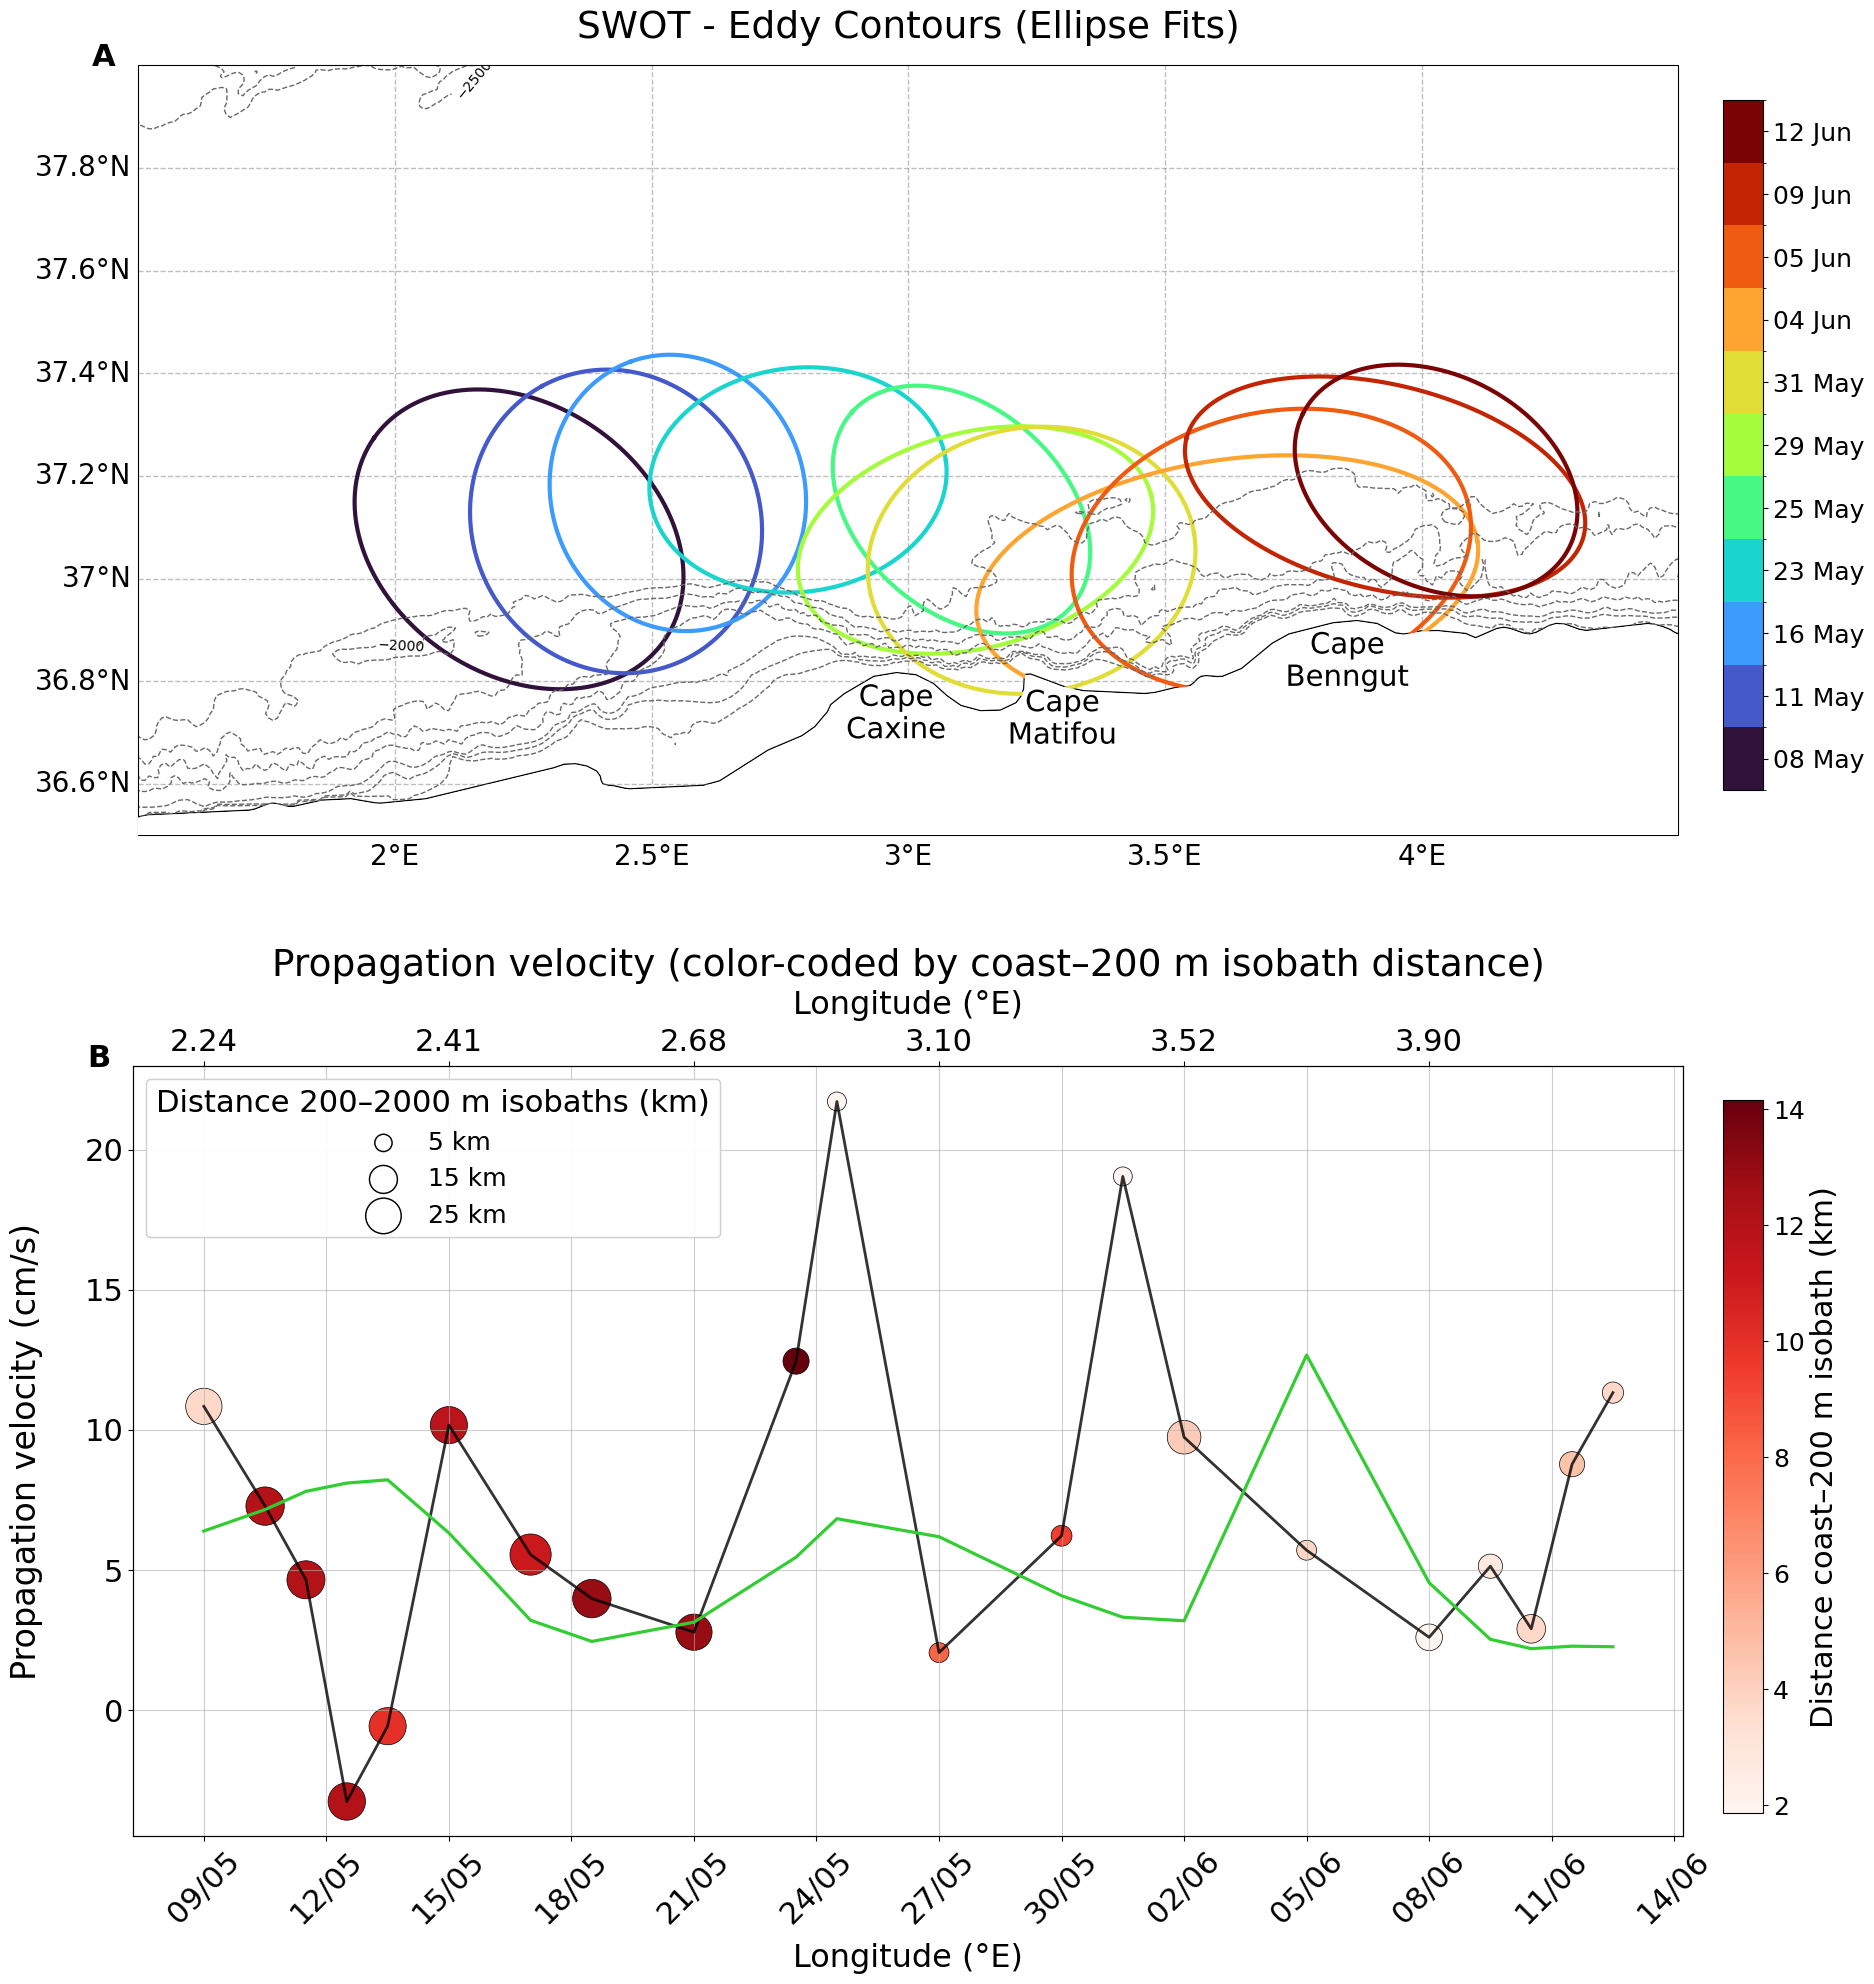

In [53]:
fig = plt.figure(figsize=(20, 23))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1], wspace=0.15, hspace=0.3)

# --------------------------------------------
# Panel A — Eddy contours from SWOT (ellipse fits)
# --------------------------------------------
ax2 = fig.add_subplot(gs[0, :2], projection=ccrs.PlateCarree())

ax2.set_extent([1.5, 4.5, 36.5, 38], crs=ccrs.PlateCarree())
ax2.coastlines(resolution='10m', color='k', linewidth=2)
ax2.add_feature(cartopy.feature.LAND, facecolor='white', zorder=10)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')   
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
gl.right_labels = False; gl.top_labels = False
ax2.add_feature(cartopy.feature.LAND, facecolor='white', zorder=10) 

# Plot all fitted ellipses with color-coded temporal sequence
for i, model in enumerate(ellipse_models):
    color = cmap(norm(i))
    plot_ellipse_on_map(ax2, model, color=color)

#  Bathymetry contours
contour = ax2.contour(lon, lat, bathymetry, levels=[-2500, -2000, -1500, -1000, -500, -350, -200],
                     colors='dimgray', linewidths=1, transform=ccrs.PlateCarree())
ax2.clabel(contour, inline=True, fontsize=10, colors='k')  

# Title
ax2.set_title('SWOT - Eddy Contours (Ellipse Fits)', fontsize=27, pad=20) 

# Colorbar 
cbar_ax2 = fig.add_axes([0.92, 0.565, 0.02, 0.3]) 
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax2, orientation='vertical')
cbar.set_ticks(0.5 + np.arange(len(contour_dates_dt)))
cbar.set_ticklabels([d.strftime('%d %b') for d in contour_dates_dt], rotation=0)
cbar.ax.tick_params(labelsize=18)

# Capes labels
txt1 = ax2.text(0.492, 0.197, 'Cape\nCaxine', transform=ax2.transAxes, fontsize=21, ha='center', va='top', zorder=20, color='k')
txt1.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

txt2 = ax2.text(0.6, 0.19, 'Cape\nMatifou', transform=ax2.transAxes, fontsize=21, ha='center', va='top', zorder=20, color='k')
txt2.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

txt3 = ax2.text(0.785, 0.265, 'Cape\nBenngut', transform=ax2.transAxes, fontsize=21, ha='center', va='top', zorder=20, color='k')
txt3.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])


# --------------------------------------------
# Panel B — Eddy propagation velocity (SWOT vs conventional altimetry)
# --------------------------------------------
ax3 = fig.add_subplot(gs[1, :2])

# Axis labels
ax3.set_xlabel("Longitude (°E)", fontsize=23, labelpad=10)
ax3.set_ylabel("Propagation velocity (cm/s)", fontsize=24, labelpad=30)
ax3.set_title("Propagation velocity (color-coded by coast–200 m isobath distance)",
              fontsize=27, pad=10)

# Format x-axis for dates
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax3.tick_params(axis='x', rotation=45, labelsize=23)
ax3.tick_params(labelsize=22)

ax3.grid(True, linestyle="-", alpha=0.6)

# Marker sizes based on isobath-sharpness metric
marker_sizes = 50 + (array_distances_km_sharp_2000[:-1] ** 1.4) * 7

# Scatter
sc = ax3.scatter(
    dates, velocities_swot,
    c=array_distances_km[:-1], cmap="Reds",
    s=marker_sizes,
    edgecolor="k", linewidth=0.5
)

# SWOT and conventional altimetry velocities
ax3.plot(dates, velocities_swot, color="k", linewidth=2, alpha=0.8, label="SWOT")
ax3.plot(dates, velocities_convalt, color="limegreen", linewidth=2.3, label="Conventional Altimetry")

# Twin x-axis for longitude
ax4 = ax3.twiny()
ax4.set_xlim(ax3.get_xlim())
tick_indices = [0, 5, 8, 11, 14, 16]
ax4.set_xticks([dates[idx] for idx in tick_indices])
ax4.set_xticklabels(["2.24", "2.41", "2.68", "3.10", "3.52", "3.90"],
                    fontsize=22, color='k')
ax4.set_xlabel("Longitude (°E)", fontsize=23, labelpad=10)

# Colorbar for coast–200m distance
cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.31])
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_label("Distance coast–200 m isobath (km)", fontsize=22)
cbar.ax.tick_params(labelsize=18)

# Legends
line_handles, line_labels = ax3.get_legend_handles_labels()
line_handles = [h for h in line_handles if isinstance(h, Line2D)]
ax3.legend(handles=line_handles, loc="upper right", fontsize=20)

# Marker-size legend (200–2000m distance)
legend_sizes_km = [5, 15, 25]
legend_markers = [
    ax3.scatter([], [], c="None", s=30 + km*25, edgecolor="k", label=f"{km} km")
    for km in legend_sizes_km
]
size_legend = ax3.legend(
    handles=legend_markers, title="Distance 200–2000 m isobaths (km)",
    title_fontsize=22, loc="upper left", fontsize=18, frameon=True
)
ax3.add_artist(size_legend)

# Panel labels A and B
ax2.text(-0.03, 1, 'A', transform=ax2.transAxes, fontsize=22, fontweight='bold')
ax3.text(-0.03, 1, 'B', transform=ax3.transAxes, fontsize=22, fontweight='bold')

plt.show()